In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/my-pose-model"

Mounted at /content/drive
/content/drive/MyDrive/my-pose-model


# 전처리

In [ ]:
from zipfile import ZipFile
import os

# ZIP 파일의 경로 지정
zip_file_path1 = "pose1.zip"
zip_file_path2 = "pose2.zip"
zip_file_path3 = "pose3.zip"
zip_file_path4 = "pose4.zip"
zip_file_path5 = "pose5.zip"

# ZIP 파일 해제할 폴더 지정
extracted_folder_path1 = "./pose1"
extracted_folder_path2 = "./pose2"
extracted_folder_path3 = "./pose3"
extracted_folder_path4 = "./pose4"
extracted_folder_path5 = "./pose5"

# ZIP 파일 해제
with ZipFile(zip_file_path1, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path1)

with ZipFile(zip_file_path2, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path2)

with ZipFile(zip_file_path3, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path3)

with ZipFile(zip_file_path4, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path4)

with ZipFile(zip_file_path5, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path5)

In [ ]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display
import pandas as pd

In [ ]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [ ]:
model_name = "movenet_lightning"

if "tflite" in model_name:
    if "movenet_lightning_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_f16" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
        input_size = 256
    elif "movenet_lightning_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
        input_size = 192
    elif "movenet_thunder_int8" in model_name:
        !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
        input_size = 256
    else:
        raise ValueError("Unsupported model name: %s" % model_name)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path="model.tflite")
    interpreter.allocate_tensors()

    def movenet(input_image):
      """Runs detection on an input image.

      Args:
        input_image: A [1, height, width, 3] tensor represents the input image
          pixels. Note that the height/width should already be resized and match the
          expected input resolution of the model before passing into this function.

      Returns:
        A [1, 1, 17, 3] float numpy array representing the predicted keypoint
        coordinates and scores.
      """
      # TF Lite format expects tensor type of uint8.
      input_image = tf.cast(input_image, dtype=tf.uint8)
      input_details = interpreter.get_input_details()
      output_details = interpreter.get_output_details()
      interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
      # Invoke inference.
      interpreter.invoke()
      # Get the model prediction.
      keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
      return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
      module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
      input_size = 192
  elif "movenet_thunder" in model_name:
      module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
      input_size = 256
  else:
      raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

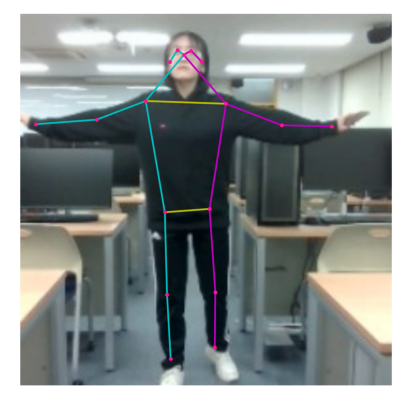

In [ ]:
# Load the input image.
from PIL import Image
image_path = './pose5/0.jpg'
# image = tf.io.read_file(image_path)
# image = tf.image.decode_jpeg(image_path)
# # Resize and pad the image to keep the aspect ratio and fit the expected size.
# input_image = tf.expand_dims(image, axis=0)
# input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

with Image.open(image_path) as img:
    # Convert the image to a TensorFlow tensor
    image = tf.convert_to_tensor(img)

input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [ ]:
image_path = './pose2/0.jpg'

with Image.open(image_path) as img:
    image = tf.convert_to_tensor(img)
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
# Run model inference.
keypoints_with_scores = movenet(input_image)
keypoints_with_scores=keypoints_with_scores.flatten()

In [ ]:
folder_path = '/content/drive/MyDrive/my-pose-model/pose1'
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
paths = [os.path.join(folder_path, file) for file in jpg_files]

i=0
column_names = [str(i) for i in range(51)]
df1 = pd.DataFrame(columns=column_names)
for path in paths:
  image_path = path
  with Image.open(image_path) as img:
      image = tf.convert_to_tensor(img)
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  keypoints_with_scores = movenet(input_image)
  keypoints_with_scores=keypoints_with_scores.flatten()
  df1.loc[i] = keypoints_with_scores
  i+=1
df1['label']=1

In [ ]:
folder_path = '/content/drive/MyDrive/my-pose-model/pose2'
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
paths = [os.path.join(folder_path, file) for file in jpg_files]
i=0
column_names = [str(i) for i in range(51)]
df2 = pd.DataFrame(columns=column_names)
for path in paths:
  image_path = path
  with Image.open(image_path) as img:
      image = tf.convert_to_tensor(img)
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  keypoints_with_scores = movenet(input_image)
  keypoints_with_scores=keypoints_with_scores.flatten()
  df2.loc[i] = keypoints_with_scores
  i+=1
df2['label']=1

In [ ]:
folder_path = '/content/drive/MyDrive/my-pose-model/pose3'
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
paths = [os.path.join(folder_path, file) for file in jpg_files]
i=0
column_names = [str(i) for i in range(51)]
df3 = pd.DataFrame(columns=column_names)
for path in paths:
  image_path = path
  with Image.open(image_path) as img:
      image = tf.convert_to_tensor(img)
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  keypoints_with_scores = movenet(input_image)
  keypoints_with_scores=keypoints_with_scores.flatten()
  df3.loc[i] = keypoints_with_scores
  i+=1
df3['label']=1

In [ ]:
folder_path = '/content/drive/MyDrive/my-pose-model/pose4'
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
paths = [os.path.join(folder_path, file) for file in jpg_files]
i=0
column_names = [str(i) for i in range(51)]
df4 = pd.DataFrame(columns=column_names)
for path in paths:
  image_path = path
  with Image.open(image_path) as img:
      image = tf.convert_to_tensor(img)
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  keypoints_with_scores = movenet(input_image)
  keypoints_with_scores=keypoints_with_scores.flatten()
  df4.loc[i] = keypoints_with_scores
  i+=1
df4['label']=1

In [ ]:
folder_path = '/content/drive/MyDrive/my-pose-model/pose5'
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
paths = [os.path.join(folder_path, file) for file in jpg_files]
i=0
column_names = [str(i) for i in range(51)]
df5 = pd.DataFrame(columns=column_names)
for path in paths:
  image_path = path
  with Image.open(image_path) as img:
      image = tf.convert_to_tensor(img)
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
  keypoints_with_scores = movenet(input_image)
  keypoints_with_scores=keypoints_with_scores.flatten()
  df5.loc[i] = keypoints_with_scores
  i+=1
df5['label']=1

In [ ]:
df5['label']=5
df4['label']=4
df3['label']=3
df2['label']=2
df1['label']=1


In [ ]:
dfs = [df1, df2, df3, df4, df5]

# 리스트에 있는 데이터프레임들을 합치기
result_df = pd.concat(dfs, ignore_index=True)

In [ ]:
result_df = result_df.sample(frac=1, random_state=42)

In [ ]:
result_df.to_csv("./train_data.csv", index=False)

In [ ]:
result_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,label
4711,0.129966,0.466054,0.849203,0.115344,0.486036,0.867973,0.116544,0.446173,0.914153,0.138529,...,0.758320,0.415029,0.928889,0.918548,0.531171,0.944854,0.916203,0.405232,0.943129,5
691,0.114928,0.511837,0.829148,0.101949,0.533078,0.584622,0.103605,0.494175,0.654527,0.130878,...,0.754619,0.419759,0.836575,0.910795,0.524242,0.885856,0.910483,0.409360,0.821611,1
65,0.136537,0.464696,0.714143,0.128191,0.482804,0.615055,0.127298,0.450485,0.595443,0.155125,...,0.694747,0.425676,0.790729,0.846819,0.517767,0.768221,0.849144,0.426204,0.810187,1
3426,0.353758,0.437822,0.445549,0.341512,0.455407,0.527118,0.340196,0.425161,0.618085,0.355628,...,0.880205,0.402300,0.692344,0.974492,0.488366,0.325551,0.978990,0.406184,0.316777,4
4683,0.097930,0.499554,0.705041,0.081137,0.521856,0.646458,0.081684,0.477904,0.585668,0.112220,...,0.794570,0.417727,0.894245,0.978819,0.556076,0.931498,0.970959,0.405181,0.890521,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.109201,0.505858,0.870328,0.098981,0.528571,0.874422,0.097793,0.488596,0.894823,0.126764,...,0.759250,0.431711,0.908375,0.954895,0.541466,0.816392,0.926220,0.421551,0.875545,5
466,0.113362,0.473064,0.741592,0.101397,0.491572,0.610291,0.104363,0.454837,0.606480,0.131594,...,0.722240,0.413105,0.819874,0.868481,0.516220,0.675248,0.878187,0.410382,0.615005,1
3092,0.372464,0.461325,0.529333,0.363842,0.469839,0.396399,0.363847,0.450374,0.644868,0.377540,...,0.802042,0.419324,0.747220,0.946307,0.485795,0.825448,0.948717,0.401585,0.780307,4
3772,0.352990,0.424331,0.578592,0.338446,0.439271,0.477007,0.337459,0.410647,0.589138,0.349825,...,0.856530,0.391717,0.678828,0.979574,0.470264,0.724721,0.984634,0.378810,0.611051,4


# 학습

In [ ]:
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [ ]:
LEFT_HIP = 12
RIGHT_HIP = 11
LEFT_SHOULDER = 6
RIGHT_SHOULDER = 5

In [ ]:
train_df = pd.read_csv("./train_data.csv")
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,label
0,0.129966,0.466054,0.849203,0.115344,0.486036,0.867973,0.116544,0.446173,0.914153,0.138529,...,0.758320,0.415029,0.928889,0.918548,0.531171,0.944854,0.916203,0.405232,0.943129,5
1,0.114928,0.511837,0.829148,0.101949,0.533078,0.584622,0.103605,0.494175,0.654527,0.130878,...,0.754619,0.419759,0.836575,0.910795,0.524242,0.885856,0.910483,0.409360,0.821611,1
2,0.136537,0.464696,0.714143,0.128191,0.482804,0.615055,0.127298,0.450485,0.595443,0.155125,...,0.694747,0.425676,0.790729,0.846819,0.517767,0.768221,0.849144,0.426204,0.810187,1
3,0.353758,0.437822,0.445549,0.341512,0.455407,0.527118,0.340196,0.425161,0.618085,0.355628,...,0.880205,0.402300,0.692344,0.974492,0.488366,0.325551,0.978990,0.406184,0.316777,4
4,0.097930,0.499554,0.705041,0.081137,0.521856,0.646458,0.081684,0.477904,0.585668,0.112220,...,0.794570,0.417727,0.894245,0.978819,0.556076,0.931498,0.970959,0.405181,0.890521,5


In [ ]:
x_train = train_df.drop(columns=['label'])
y_train = train_df['label']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.15)

In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart, axis=1)
  right = tf.gather(landmarks, right_bodypart, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, LEFT_HIP,
                                 RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, LEFT_SHOULDER,
                                      RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, LEFT_HIP,
                                     RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, LEFT_HIP,
                                 RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [ ]:
# Define the model
inputs = keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(5, activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape_6 (Reshape)         (None, 17, 3)                0         ['input_6[0][0]']             
                                                                                                  
 tf.__operators__.getitem_1  (None, 17, 2)                0         ['reshape_6[0][0]']           
 1 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.compat.v1.gather_10 (TF  (None, 2)                    0         ['tf.__operators__.getitem

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_val_one_hot = to_categorical(y_val, num_classes=5)

history = model.fit(X_train, y_train_one_hot,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val_one_hot),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
247/269 [==========================>...] - ETA: 0s - loss: 1.1616 - accuracy: 0.6829
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to weights.best.hdf5
269/269 [==============================] - 2s 4ms/step - loss: 1.1024 - accuracy: 0.7046 - val_loss: 0.2422 - val_accuracy: 1.0000
Epoch 2/200
 49/269 [====>.........................] - ETA: 0s - loss: 0.3210 - accuracy: 0.9592

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


257/269 [===========================>..] - ETA: 0s - loss: 0.1849 - accuracy: 0.9786
Epoch 2: val_accuracy did not improve from 1.00000
269/269 [==============================] - 1s 3ms/step - loss: 0.1805 - accuracy: 0.9793 - val_loss: 0.0126 - val_accuracy: 1.0000
Epoch 3/200
263/269 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9931
Epoch 3: val_accuracy did not improve from 1.00000
269/269 [==============================] - 1s 2ms/step - loss: 0.0602 - accuracy: 0.9932 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 4/200
247/269 [==========================>...] - ETA: 0s - loss: 0.0302 - accuracy: 0.9972
Epoch 4: val_accuracy did not improve from 1.00000
269/269 [==============================] - 1s 3ms/step - loss: 0.0296 - accuracy: 0.9974 - val_loss: 7.0106e-04 - val_accuracy: 1.0000
Epoch 5/200
263/269 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9969
Epoch 5: val_accuracy did not improve from 1.00000
269/269 [==============

In [ ]:
model = tf.keras.models.load_model('weights.best.hdf5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('customed_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path='customed_model.tflite')
interpreter.allocate_tensors()

In [ ]:

input_data = np.array(train_df.iloc[0,0:-1].astype(np.float32)).reshape(1, 51)

# 입력 데이터를 모델에 전달
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], input_data)

# 모델 실행
interpreter.invoke()

# 출력 얻기
output_details = interpreter.get_output_details()
output_data = interpreter.get_tensor(output_details[0]['index'])


In [ ]:
output_data.max()

0.9580676